In [2]:
%matplotlib inline
from astLib.astCoords import decimal2dms, decimal2hms, hms2decimal, dms2decimal
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck15
from astropy.io import ascii, fits
from astropy.table import Column, Table, join, vstack
from cartopy import crs
from matplotlib import pyplot as plt, ticker
import numpy as np

# my own code
from astro.clusters import catalogs, conversions
from plottery.plotutils import savefig, update_rcParams
update_rcParams()

In [3]:
import astropy
astropy.__version__

'5.1'

# Load catalogs
Remember than Planck masses are not calibrated

In [4]:
actcols = ('name', 'RADeg', 'decDeg', 'redshift',
           'M500cCal', 'M500cCal_errMinus', 'M500cCal_errPlus')
pszcols = ('NAME', 'RA', 'DEC', 'REDSHIFT',
           'MSZ', 'MSZ_ERR_LOW', 'MSZ_ERR_UP')
colnames = ('name', 'ra', 'dec', 'z', 'm500', 'm500lo', 'm500hi')
#actcols, pszcols = [{key: name for key, name in zip(colnames, cols)}
                    #for cols in (actcols, pszcols)]

In [5]:
psz = catalogs.load('psz2')
psz.rename_columns(pszcols, colnames)
#for col in ('m500','m500lo','m500hi'):
    #psz[col] /= 0.8
psz.sort('m500', reverse=True)

In [6]:
act = Table(fits.getdata('../../catalogs/actpol/dr5/DR5_cluster-catalog_v1.1.fits'))
act.rename_columns(actcols, colnames)
act.sort('m500', reverse=True)

Apply footprint masks

In [7]:
cats = [act, psz]
for i, (cat, cols) in enumerate(zip(cats, (actcols, pszcols))):
    for key in ('z','m500','m500lo','m500hi','SNR'):
        cat[key].format = '%.2f'
    for key in ('ra','dec'):
        cat[key].format = '%.6f'
    cat['hms'] = [decimal2hms(ra, ':')[:-2] for ra in cat['ra']]
    cat['dms'] = [decimal2dms(dec, ':')[:-3] for dec in cat['dec']]
    cat['coords'] = SkyCoord(ra=cat['ra']*u.deg, dec=cat['dec']*u.deg)
    gal = cat['coords'].transform_to('galactic')
    cat['l'] = gal.l
    cat['b'] = gal.b
    mask = (cat['l'] > 180*u.deg) & (np.abs(cat['b']) > 10*u.deg) \
        & (cat['dec'] > -80) & (cat['dec'] < 5) & (cat['z'] < 0.6)
    cats[i] = cat[mask]
    print(mask.sum())
act, psz = cats
# for later use
psz.add_column(np.arange(psz['name'].size, dtype=int), name='index')
act.add_column(np.arange(act['name'].size, dtype=int), name='index')

1090
613


So there are 1,090 and 613 clusters within the allowed region of the sky in the ACT and PSZ catalogues, respectively.

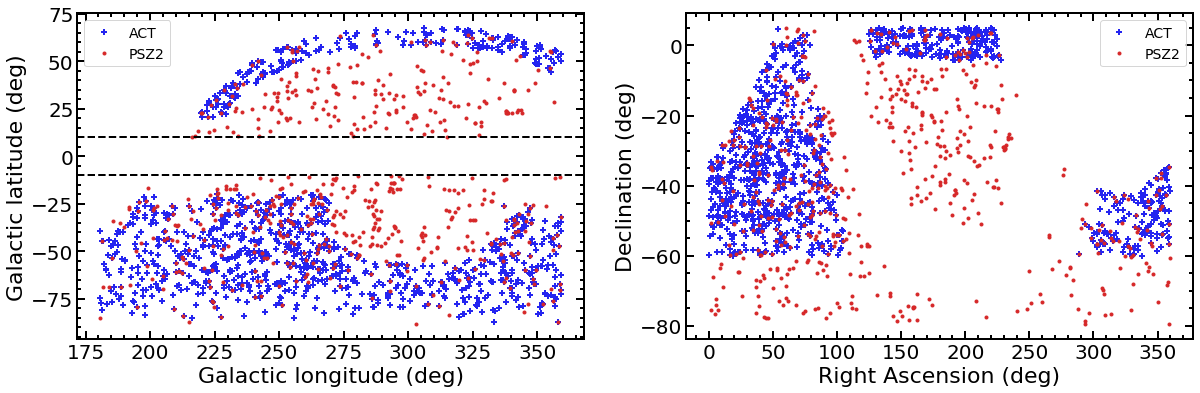

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))
ax = axes[0]
ax.plot(act['l'], act['b'], '+', mew=2, label='ACT')
ax.plot(psz['l'], psz['b'], 'C3.', label='PSZ2')
ax.axhline(-10, ls='--', color='k')
ax.axhline(10, ls='--', color='k')
ax.set(xlabel='Galactic longitude (deg)', ylabel='Galactic latitude (deg)')
ax.legend(loc='upper left', fontsize=14)
ax = axes[1]
ax.plot(act['ra'], act['dec'], '+', mew=2, label='ACT')
ax.plot(psz['ra'], psz['dec'], 'C3.', label='PSZ2')
ax.set(xlabel='Right Ascension (deg)', ylabel='Declination (deg)')
ax.legend(loc='upper right', fontsize=14)

Let's match both catalogues

In [9]:
dist = psz['coords'].separation(act['coords'][:,None])
act_in_psz = np.argmin(dist, axis=0)
psz_in_act = np.argmin(dist, axis=1)
dist.shape

(1090, 613)

using a $10'$ radius. Being generous here since we'll be observing large areas of the sky for each cluster

In [10]:
matchdist = 10*u.arcmin
act_in_psz_dist = np.min(dist, axis=0)
psz_in_act_dist = np.min(dist, axis=1)
act_in_psz_match = (act_in_psz_dist < matchdist)
psz_in_act_match = (psz_in_act_dist < matchdist)
act_in_psz_match.size, act_in_psz_match.sum(), psz_in_act_match.sum()

(613, 172, 181)

170-180 objects in common. The reason why the numbers are different is that many ACT clusters can coincide with a single PSZ2 source at these separations (also many may not be at the same redshift - we kind of need to control for that). Let's store cross indices and masses for easy access

In [11]:
act['PSZ_index'] = psz_in_act
act['PSZ_index'][~psz_in_act_match] = -99
act['PSZ_separation'] = psz_in_act_match
act['PSZ_name'] = psz['name'][psz_in_act]
act['PSZ_name'][~psz_in_act_match] = '--'
act['PSZ_m500'] = psz['m500'][psz_in_act]
act['PSZ_m500'][~psz_in_act_match] = -99

psz['ACT_index'] = act_in_psz
psz['ACT_index'][~act_in_psz_match] = -99
psz['ACT_sepatation'] = act_in_psz_match
psz['ACT_name'] = act['name'][act_in_psz]
psz['ACT_name'][~act_in_psz_match] = '--'
psz['ACT_m500'] = act['m500'][act_in_psz]
psz['ACT_m500'][~act_in_psz_match] = -99

# Low-redshift sample

Find a maximum ``Nlowz`` clusters in the low-z redshift range

In [12]:
lowzrng = (0.03, 0.07)
Nlowz = 60

In [13]:
psz_lowz = (psz['z'] >= lowzrng[0]) & (psz['z'] <= lowzrng[1])
psz_lowz.sum()

46

So there are 46 clusters in this redshift range in PSZ2.

In [14]:
np.array(psz['m500'][psz_lowz])

array([7.9394145, 7.0358543, 6.853962 , 6.636994 , 4.786142 , 4.6276913,
       4.22461  , 3.6887183, 3.506744 , 3.4528549, 3.2445817, 3.2120986,
       2.8883076, 2.8694983, 2.8182993, 2.7138853, 2.5786262, 2.481668 ,
       2.4687192, 2.4429998, 2.3943427, 2.3838437, 2.303061 , 2.2523923,
       2.120057 , 2.0591664, 1.9178208, 1.8439797, 1.8404189, 1.8367378,
       1.807948 , 1.8021517, 1.8016499, 1.7799062, 1.754438 , 1.7065862,
       1.7024442, 1.6663923, 1.5466777, 1.5343101, 1.530876 , 1.5185853,
       1.5162448, 1.4643501, 1.4547063, 1.126739 ], dtype=float32)

Are there ACT clusters in this redshift range?

In [15]:
act_lowz = (act['z'] >= lowzrng[0]) & (act['z'] <= lowzrng[1])
act_lowz.sum()

6

In [16]:
act['name','z','m500','SNR'][act_lowz]

name,z,m500,SNR
str19,float64,float64,float64
ACT-CL J0507.6-0915,0.04,7.30,4.92
ACT-CL J0600.7-5836,0.04,5.67,4.98
ACT-CL J2012.4-5649,0.06,5.67,7.23
ACT-CL J0342.9-5337,0.06,4.53,5.53
ACT-CL J2357.0-3445,0.05,4.26,7.02
ACT-CL J2313.9-4243,0.06,3.39,5.20


These are A3158, A536, A560, A3667, AS1101, A4059, in that order.

Are they in PSZ?

In [17]:
d = act['coords'][act_lowz].separation(psz['coords'][psz_lowz][:,None])
closest = np.min(d, axis=0)
closest

<Angle [9.26672257, 4.90625453, 0.02193704, 0.03347553, 0.03602238,
        0.05791278] deg>

So it appears that 4 of them are; A536 and A560 seem to be missing (they are also the two lowest-SNR in ACT in this redshift range, though not the two lowest mass). Let's include them in the sample since anyway we are below the 50 clusters mark with PSZ alone.

### Store full catalogue

In [18]:
def combine_psz_act(psz_mask, act_mask):
    act_tbl = act['index','name','hms','dms','z','m500','m500lo','m500hi','PSZ_name'][act_mask]
    act_tbl.rename_columns(('name','PSZ_name'), ('ACT_name','name'))
    merged = join(psz['index','name','hms','dms','z','m500','m500lo','m500hi'][psz_mask],
                  act_tbl, keys=('name',), join_type='outer', table_names=('PSZ','ACT'))
    for col in ('hms','dms','z','m500','m500lo','m500hi')[::-1]:
        merged.add_column(
            [psz_val if act_mask else act_val
             for (psz_val, act_val), (psz_mask, act_mask)
             in zip(merged[f'{col}_PSZ',f'{col}_ACT'], merged[f'{col}_PSZ',f'{col}_ACT'].mask)],
            name=col, index=1)
    # put name right after index
    names = [name if name != '--' else act_name for name, act_name in merged['name','ACT_name']]
    merged.remove_column('name')
    merged.add_column(names, name='name', index=0)
    for col in ('m500','m500lo','m500hi'):
        merged[col].format = '%.2f'
    merged['z'].format = '%.3f'
    merged.sort('hms')
    merged.add_column(np.arange(merged['name'].size, dtype=int), name='index', index=0)
    return merged

Merged PSZ+ACT table. If a cluster is present in both PSZ2 and ACT, the first columns contain the PSZ name and the ACT coordinates, redshift and mass.

In [19]:
lowz = combine_psz_act(psz_lowz, act_lowz)
lowz.write('catalogues/chances_clusters_lowz_psz2_act.txt',
           format='ascii.fixed_width', overwrite=True)
lowz

index,name,index_PSZ,hms,dms,z,m500,m500lo,m500hi,hms_PSZ,dms_PSZ,z_PSZ,m500_PSZ,m500lo_PSZ,m500hi_PSZ,index_ACT,ACT_name,hms_ACT,dms_ACT,z_ACT,m500_ACT,m500lo_ACT,m500hi_ACT
int64,str19,int64,str10,str9,float64,float64,float64,float64,str10,str9,float32,float32,float32,float32,int64,str19,str10,str9,float64,float64,float64,float64
0,PSZ2 G344.99-81.88,374,00:25:31.5,-33:00:21,0.049,1.45,0.18,0.18,00:25:31.5,-33:00:21,0.05,1.45,0.18,0.18,--,--,--,--,--,--,--,--
1,PSZ2 G220.74-58.91,354,03:11:28.1,-26:56:09,0.068,1.92,0.28,0.26,03:11:28.1,-26:56:09,0.07,1.92,0.28,0.26,--,--,--,--,--,--,--,--
2,PSZ2 G247.56-56.06,360,03:22:20.1,-41:20:58,0.064,1.80,0.20,0.19,03:22:20.1,-41:20:58,0.06,1.80,0.20,0.19,--,--,--,--,--,--,--,--
3,PSZ2 G265.02-48.96,220,03:42:58.0,-53:37:48,0.060,4.53,1.30,1.72,03:42:46.9,-53:36:39,0.06,4.22,0.13,0.15,239,ACT-CL J0342.9-5337,03:42:58.0,-53:37:48,0.06,4.53,1.30,1.72
4,PSZ2 G269.36-47.20,369,03:45:43.5,-56:58:12,0.057,1.53,0.30,0.24,03:45:43.5,-56:58:12,0.06,1.53,0.30,0.24,--,--,--,--,--,--,--,--
5,PSZ2 G230.29-47.13,355,04:08:23.0,-30:59:28,0.060,1.84,0.18,0.17,04:08:23.0,-30:59:28,0.06,1.84,0.18,0.17,--,--,--,--,--,--,--,--
6,PSZ2 G240.80-46.51,371,04:13:58.7,-38:06:45,0.050,1.52,0.17,0.16,04:13:58.7,-38:06:45,0.05,1.52,0.17,0.16,--,--,--,--,--,--,--,--
7,PSZ2 G272.08-40.16,65,04:31:14.2,-61:24:25,0.059,6.64,0.12,0.11,04:31:14.2,-61:24:25,0.06,6.64,0.12,0.11,--,--,--,--,--,--,--,--
8,PSZ2 G209.54-36.50,312,04:33:30.3,-13:14:21,0.033,2.71,0.15,0.15,04:33:30.3,-13:14:21,0.03,2.71,0.15,0.15,--,--,--,--,--,--,--,--


## Load Chris' sample

(Only looking at the low-z redshift range)

In [20]:
lowz0 = ascii.read('CHANCES low-z clusters - WINGS_CHANCES.csv')
lowz0.rename_columns(
    ('Cluster Name', 'RA_J2000', 'Dec_J2000', 'Z'),
    ('name','ra','dec','z'))
lowz0 = lowz0[lowz0['z'] > 0.03]
lowz0

name,ra,dec,z,Gal_Long,Gal_Latitude,Lx,VST,AAO_redshifts,SPLUS,Comments
str7,float64,float64,float64,float64,float64,float64,str1,int64,str6,str27
A0500,69.716,-22.1,0.067,220.556,-38.49,0.72,Y,478,2020B,--
A0548b,86.366,-25.916,0.044,230.469,-25.248,0.15,N,0,2021B,--
A0754,137.133,-9.616,0.054,239.185,24.707,4.08,Y,423,2021B,--
A0780,139.525,-12.083,0.057,242.915,25.101,3.38,N,0,2021B,--
A0957,153.408,0.916,0.045,240.931,43.981,0.4,Y,154,SPLUS,--
A0970,154.391,-10.666,0.059,253.075,36.897,0.77,Y,136,SPLUS,--
A1069,159.929,-8.683,0.062,256.585,42.035,0.48,Y,496,SPLUS,--
A1631a,193.216,-15.4,0.047,303.441,47.47,0.37,Y,673,SPLUS,--
A1644,194.295,-17.4,0.048,304.885,45.449,1.8,N,0,SPLUS,--


Match to the PSZ+ACT catalogue

In [21]:
lowz0_coords = SkyCoord(ra=lowz0['ra'], dec=lowz0['dec'], unit='deg', frame='icrs')
coords = SkyCoord([f'{hms} {dms}' for hms, dms in lowz['hms','dms']],
                  frame='icrs', unit=(u.hourangle, u.deg))
sep = lowz0_coords.separation(coords[:,None])
minsep = np.min(sep, axis=0)
jminsep = np.argmin(sep, axis=0)
minsep

<Angle [6.51108081e-02, 8.36893295e-01, 1.14134213e-01, 3.29755438e+00,
        1.87741778e+00, 6.93609988e-02, 6.93562544e-02, 1.14236056e-01,
        2.39242874e-02, 5.49771881e-02, 1.72869647e+00, 2.20228131e+00,
        3.35011754e-02, 6.42067981e-02, 4.31264030e-02, 2.01437119e-01,
        6.64757147e-02, 1.43249236e-02, 6.96000460e-02, 2.21070196e-01,
        3.35783013e-01, 3.81906523e-01, 1.69917256e-02, 8.35310369e-01,
        2.99282660e-02, 1.56153829e+00, 5.52038614e-02, 1.48586165e-02,
        1.62157609e-01, 4.72692950e-02, 5.24624751e-03, 4.76814160e-03,
        1.20280702e-02, 7.34935989e+00, 8.46243988e+00, 1.38512110e-02,
        1.00210448e-01, 1.08157872e-02, 2.56745821e-02, 3.83743868e-02] deg>

What sorts of areas will we really be observing? Let's say these clusters have $M_{200}\sim10^{14}\,\mathrm{M}_\odot$. Then,

In [22]:
r200 = conversions.rsph(1e14, np.array([0.03, 0.07]))
r200

array([0.94879332, 0.93688437])

About a Mpc. Let's now say we observe 3 times $r_{200}$,

In [23]:
(3*u.Mpc / Planck15.kpc_proper_per_arcmin([0.03,0.07])).to(u.arcmin)

<Quantity [80.57189307, 36.21609972] arcmin>

so at least half a degree. Let's take half that, $15'$:

In [24]:
lowz_match_dist = 15 * u.arcmin
matches = (minsep < lowz_match_dist)
matches.sum()

29

29 ACT+PSZ clusters that would be observed if we only observed the original CHANCES sample (I'm reluctant to call them "matches" -- note that the number of overlapping clusters does not increase much for larger separations: there are only 31 overlapping ACT+PSZ clusters if we increase the separation to $30'$.)

In [30]:
lowz0['PSZ_name'] = [lowz['name'][jminsep[i]] if matches[i] else '--' for i in range(lowz0['name'].size)]
lowz0['m500'] = [lowz['m500'][jminsep[i]] if matches[i] else -1 for i in range(lowz0['name'].size)]
lowz0['name','PSZ_name','m500']

name,PSZ_name,m500
str7,str18,float64
A0500,PSZ2 G220.53-38.55,2.3943426609039307
A0548b,--,-1.0
A0754,PSZ2 G239.29+24.75,6.853961944580078
A0780,--,-1.0
A0957,--,-1.0
A0970,PSZ2 G253.04+36.83,2.303061008453369
A1069,PSZ2 G256.67+42.05,1.8021516799926758
A1631a,PSZ2 G303.56+47.54,1.7024441957473755
A1644,PSZ2 G304.91+45.43,3.688718318939209


In [31]:
minsep_psz = np.min(sep, axis=1)
jminsep_psz = np.argmin(sep, axis=1) # size 48
np.unique(jminsep_psz[minsep_psz < lowz_match_dist]).size

29

i.e., these are unique matches. Our low-z candidates catalogue therefore contains 48 + (40-29) = 59 clusters.

In [32]:
lowz_all = vstack([lowz0, lowz[minsep_psz > lowz_match_dist]])
n = lowz_all['name'].size
lowz_all['PSZ_name'] = [row['name'] if row['name'][:4] == 'PSZ2' else row['PSZ_name'] for row in lowz_all]
lowz_all = lowz_all[lowz_all.colnames[:18]]
lowz_all.remove_column('index')
lowz_all_coords = [SkyCoord(ra=row['ra'], dec=row['dec'], unit='deg', frame='icrs')
                   if not mask['ra']
                   else SkyCoord(f"{row['hms']} {row['dms']}", unit=(u.hourangle, u.deg), frame='icrs')
                   for (row, mask) in zip(lowz_all, lowz_all.mask)]
lowz_all['ra'] = [i.ra.deg for i in lowz_all_coords]
lowz_all['dec'] = [i.dec.deg for i in lowz_all_coords]
lowz_all['ra'].format = '%.6f'
lowz_all['dec'].format = '%.5f'
lowz_all['hms'] = [i.ra.to(u.hourangle).to_string(sep=':') for i in lowz_all_coords]
lowz_all['dms'] = [i.dec.to(u.deg).to_string(sep=':') for i in lowz_all_coords]
lowz_all.add_column(np.arange(lowz_all['name'].size, dtype=int), name='index', index=0)
lowz_all.write('catalogues/chances_clusters_lowz_all.txt',
               format='ascii.fixed_width', overwrite=True)
lowz_all

index,name,ra,dec,z,Gal_Long,Gal_Latitude,Lx,VST,AAO_redshifts,SPLUS,Comments,PSZ_name,m500,index_PSZ,hms,dms,m500lo
int64,str19,float64,float64,float64,float64,float64,float64,str1,int64,str6,str27,str18,float64,int64,str11,str11,float64
0,A0500,69.716000,-22.10000,0.067,220.556,-38.49,0.72,Y,478,2020B,--,PSZ2 G220.53-38.55,2.39,--,4:38:51.84,-22:06:00,--
1,A0548b,86.366000,-25.91600,0.044,230.469,-25.248,0.15,N,0,2021B,--,--,-1.00,--,5:45:27.84,-25:54:57.6,--
2,A0754,137.133000,-9.61600,0.054,239.185,24.707,4.08,Y,423,2021B,--,PSZ2 G239.29+24.75,6.85,--,9:08:31.92,-9:36:57.6,--
3,A0780,139.525000,-12.08300,0.057,242.915,25.101,3.38,N,0,2021B,--,--,-1.00,--,9:18:06,-12:04:58.8,--
4,A0957,153.408000,0.91600,0.045,240.931,43.981,0.4,Y,154,SPLUS,--,--,-1.00,--,10:13:37.92,0:54:57.6,--
5,A0970,154.391000,-10.66600,0.059,253.075,36.897,0.77,Y,136,SPLUS,--,PSZ2 G253.04+36.83,2.30,--,10:17:33.84,-10:39:57.6,--
6,A1069,159.929000,-8.68300,0.062,256.585,42.035,0.48,Y,496,SPLUS,--,PSZ2 G256.67+42.05,1.80,--,10:39:42.96,-8:40:58.8,--
7,A1631a,193.216000,-15.40000,0.047,303.441,47.47,0.37,Y,673,SPLUS,--,PSZ2 G303.56+47.54,1.70,--,12:52:51.84,-15:24:00,--
8,A1644,194.295000,-17.40000,0.048,304.885,45.449,1.8,N,0,SPLUS,--,PSZ2 G304.91+45.43,3.69,--,12:57:10.8,-17:24:00,--


# Evolution sample

In [33]:
evzrng = (0.07, 0.4)
Nev = 50

In [34]:
pszev_all = (psz['z'] > evzrng[0]) & (psz['z'] <= evzrng[1])
pszev_all.sum()

277

Now limit by mass

In [35]:
psz['m500'][pszev_all][:Nev].data

array([14.692611 , 13.1003475, 11.35923  ,  9.750274 ,  8.971329 ,
        8.860777 ,  8.768981 ,  8.75969  ,  8.392523 ,  8.025071 ,
        7.964058 ,  7.926002 ,  7.80038  ,  7.795695 ,  7.7454786,
        7.74384  ,  7.635277 ,  7.5699863,  7.5411067,  7.4210167,
        7.406209 ,  7.373215 ,  7.367692 ,  7.255627 ,  7.193831 ,
        7.1856046,  7.162284 ,  7.0047956,  6.99343  ,  6.9604278,
        6.8637824,  6.8313117,  6.8259788,  6.7752447,  6.772831 ,
        6.72489  ,  6.7165456,  6.6944194,  6.6779947,  6.6662083,
        6.6589427,  6.647714 ,  6.6418705,  6.592571 ,  6.584915 ,
        6.5251403,  6.440878 ,  6.424766 ,  6.424092 ,  6.2860823],
      dtype=float32)

So $M_{500}>6.28\times10^{14}\,\mathrm{M}_\odot$. Let's define a mask:

In [36]:
pszev = pszev_all & (psz['m500'] > 6.28)
pszev.sum()

50

## CLASH-VLT

These have lots of spectroscopy so it makes sense to include them

In [37]:
clash="""Abell_383	02:48:06.9	-03:29:32	0.187	Completed
Abell_209       01:31:57.5	-13:34:35	0.209	Completed
RXJ2129+0005	21:29:40.0	00:05:21	0.234	Completed
MS2137-2353	    21:40:12.8  -23:39:27	0.313	Completed
RXJ2248-4431	22:48:54.3	-44:31:07	0.346	Completed
MACSJ1115+01	11:15:53.3	01:29:47	0.352	Completed
MACSJ1931-26	19:31:49.6	-26:34:34	0.352	Completed
MACSJ0416-24	04:16:09.9	-24:03:58	0.396	Completed
MACSJ1206-08	12:06:12.1	-08:48:02	0.440	Completed
MACSJ0329-02	03:29:40.8	-02:11:54	0.450	Completed
RXJ1347-1145	13:47:32.0	-11:45:42	0.451	Completed
MACSJ1311-03	13:11:01.6	-03:10:40	0.494	Completed
MACSJ2129-07	21:29:26.0	-07:41:28	0.570	Completed""".split('\n')
clash = [i.split()[:-1] for i in clash]
clash = [[i[j] for i in clash] for j in range(4)]
clash[3] = np.array(clash[3], dtype=float)
clash = Table(clash, names=('name','hms','dms','z'))
clash['ra'] = [hms2decimal(ra, ':') for ra in clash['hms']]
clash['dec'] = [dms2decimal(dec, ':') for dec in clash['dms']]
clash['ra'].format = '%.6f'
clash['dec'].format = '%.6f'
clash

name,hms,dms,z,ra,dec
str12,str10,str9,float64,float64,float64
Abell_383,02:48:06.9,-03:29:32,0.187,42.028750,-3.492222
Abell_209,01:31:57.5,-13:34:35,0.209,22.989583,-13.576389
RXJ2129+0005,21:29:40.0,00:05:21,0.234,322.416667,0.089167
MS2137-2353,21:40:12.8,-23:39:27,0.313,325.053333,-23.657500
RXJ2248-4431,22:48:54.3,-44:31:07,0.346,342.226250,-44.518611
MACSJ1115+01,11:15:53.3,01:29:47,0.352,168.972083,1.496389
MACSJ1931-26,19:31:49.6,-26:34:34,0.352,292.956667,-26.576111
MACSJ0416-24,04:16:09.9,-24:03:58,0.396,64.041250,-24.066111
MACSJ1206-08,12:06:12.1,-08:48:02,0.44,181.550417,-8.800556


In [38]:
clash['coords'] = SkyCoord(ra=clash['ra'], dec=clash['dec'], unit='deg')
gal = clash['coords'].transform_to('galactic')
clash['l'] = gal.l
clash['b'] = gal.b
clash_chances_mask = (clash['z'] < 0.5) \
    & (clash['l'] > 180*u.deg) & (np.abs(clash['b']) > 10*u.deg) \
    & (clash['dec'] > -80) & (clash['dec'] < 5)
clash_chances_mask, clash_chances_mask.sum()

(array([False, False, False, False,  True,  True, False,  True,  True,
         True,  True,  True, False]),
 7)

So only 7 CLASH clusters are in the CHANCES footprint:

In [39]:
clash = clash[clash_chances_mask]
clash['name','hms','dms','z']

name,hms,dms,z
str12,str10,str9,float64
RXJ2248-4431,22:48:54.3,-44:31:07,0.346
MACSJ1115+01,11:15:53.3,01:29:47,0.352
MACSJ0416-24,04:16:09.9,-24:03:58,0.396
MACSJ1206-08,12:06:12.1,-08:48:02,0.44
MACSJ0329-02,03:29:40.8,-02:11:54,0.45
RXJ1347-1145,13:47:32.0,-11:45:42,0.451
MACSJ1311-03,13:11:01.6,-03:10:40,0.494


And how many coincide with a PSZ2 source?

In [40]:
clash_sep = clash['coords'].separation(psz['coords'][:,None])
mindist = np.min(clash_sep, axis=0)
mindist

<Angle [1.07317170e-02, 2.27796248e-02, 1.28680807e-02, 1.66091951e-02,
        3.54989304e+00, 3.00055788e-03, 1.84433762e+00] deg>

In [41]:
clash['name','hms','dms','z'][mindist < 10*u.arcmin]

name,hms,dms,z
str12,str10,str9,float64
RXJ2248-4431,22:48:54.3,-44:31:07,0.346
MACSJ1115+01,11:15:53.3,01:29:47,0.352
MACSJ0416-24,04:16:09.9,-24:03:58,0.396
MACSJ1206-08,12:06:12.1,-08:48:02,0.44
RXJ1347-1145,13:47:32.0,-11:45:42,0.451


Now need to find them in PSZ - do they pass our mass cut?

In [42]:
psz['name','hms','dms','z','m500'][np.argmin(clash_sep, axis=0)][mindist < 10*u.arcmin]

name,hms,dms,z,m500
str18,str10,str9,float32,float32
PSZ2 G349.46-59.95,22:48:51.6,-44:31:33,0.35,11.36
PSZ2 G257.09+55.61,11:15:47.8,+01:29:46,0.35,6.86
PSZ2 G221.06-44.05,04:16:08.4,-24:03:15,-1.00,0.00
PSZ2 G284.41+52.45,12:06:14.9,-08:47:19,0.44,11.18
PSZ2 G324.04+48.79,13:47:32.7,-11:45:45,0.45,11.03


In [43]:
pszev = pszev \
    | np.in1d(psz['name'], psz['name'][np.argmin(clash_sep, axis=0)][mindist < 10*u.arcmin])
pszev.size, pszev.sum()

(613, 53)

We will add the two that are not in PSZ at the very end.

In [44]:
clash_not_in_psz = (mindist > 10*u.arcmin)
clash['name','hms','dms','z'][clash_not_in_psz]

name,hms,dms,z
str12,str10,str9,float64
MACSJ0329-02,03:29:40.8,-02:11:54,0.45
MACSJ1311-03,13:11:01.6,-03:10:40,0.494


## AdvACT

How many ACT clusters pass the Evolution cuts?

In [45]:
actev = (act['z'] > evzrng[0]) & (act['z'] <= evzrng[1])
(act[actev]['PSZ_index'] > -99).sum()

132

In [46]:
(psz[pszev]['ACT_index'] > -99).sum()

25

Only 25 of the `Nev` selected from PSZ2 are in ACT. How many of the `Nact` most massive ACT clusters are we missing?

In [47]:
Nact = 50
act['m500'][actev][:Nact].data

array([18.97289444, 16.06084364, 15.23151321, 14.06227487, 12.5434389 ,
       12.29545916, 12.01096039, 11.27371324, 11.18094793, 10.65483017,
       10.52359179, 10.48742442, 10.29425772,  9.79636332,  9.49748329,
        9.10057187,  9.04435113,  9.02568817,  8.97610834,  8.67234588,
        8.60098583,  8.24154014,  8.09531217,  8.05084307,  7.83213501,
        7.77303881,  7.71438852,  7.61936834,  7.52551855,  7.49449288,
        7.47902804,  7.28588019,  7.04416565,  6.90966072,  6.85280484,
        6.81516107,  6.80109803,  6.77305895,  6.69424106,  6.61178631,
        6.52585231,  6.48553745,  6.47215459,  6.45435372,  6.38363848,
        6.34857193,  6.33983543,  6.22306271,  6.21449893,  6.20167535])

So a cut $M_{500}>6.2\times10^{14}\,\mathrm{M}_\odot$ gives us the 50 most massive ACT clusters in the CHANCES-Evolution redshift range.

In [48]:
actev_massive = actev & (act['m500'] > 6.2)
actev_massive.sum()

50

In [49]:
actev_massive_not_in_psz = actev_massive & (act['PSZ_index'] == -99)
actev_massive_not_in_psz.sum()

6

These are the massive ACT clusters that are not in PSZ2 at all:

In [50]:
act['name','z','m500'][actev_massive_not_in_psz]

name,z,m500
str19,float64,float64
ACT-CL J0237.4-2630,0.22,7.77
ACT-CL J0428.1+0121,0.39,7.29
ACT-CL J2322.2-3805,0.36,6.77
ACT-CL J0138.0-2155,0.34,6.34
ACT-CL J0040.9-4428,0.35,6.22
ACT-CL J0336.8-3929,0.40,6.20


In [51]:
query = 'sourceList=S18d_202006 and ' \
    + ' and '.join([f'name="{cl}"' for cl in act['name'][actev_massive_not_in_psz]])
query

'sourceList=S18d_202006 and name="ACT-CL J0237.4-2630" and name="ACT-CL J0428.1+0121" and name="ACT-CL J2322.2-3805" and name="ACT-CL J0138.0-2155" and name="ACT-CL J0040.9-4428" and name="ACT-CL J0336.8-3929"'

**Only 6 of the 50 most massive ACT clusters are not in the PSZ2 catalog.** They are on the low-mass end of these 50 most massive.

Of these 6 it appears only ACT-CL J0138.0-2155 is interesting enough in its own right. We will include it in the catalogue.


Did all of the other ACT clusters make it in the PSZ2 Evolution sample?

In [52]:
actev_massive_in_psz = actev_massive & (act['PSZ_index'] > -99)
psz['name','z','m500','ACT_index','ACT_name'][act['PSZ_index'][actev_massive_in_psz]]

name,z,m500,ACT_index,ACT_name
str18,float32,float32,int64,str19
PSZ2 G349.46-59.95,0.35,11.36,0,ACT-CL J2248.8-4431
PSZ2 G266.04-21.25,0.30,13.10,1,ACT-CL J0658.5-5557
PSZ2 G340.36+60.58,0.25,9.75,4,ACT-CL J1401.0+0252
PSZ2 G313.33+61.13,0.18,8.77,5,ACT-CL J1311.5-0119
PSZ2 G263.14-23.41,0.23,6.83,8,ACT-CL J0638.7-5358
PSZ2 G259.98-63.43,0.28,7.54,9,ACT-CL J0232.2-4421
PSZ2 G239.43+47.95,0.28,6.53,11,ACT-CL J1023.6+0411
PSZ2 G355.07+46.20,0.22,6.67,12,ACT-CL J1504.1-0248
PSZ2 G263.68-22.55,0.16,7.96,13,ACT-CL J0645.4-5413


In [53]:
in_both_massive_samples = \
    pszev & np.in1d(psz['name'], psz['name'][act['PSZ_index'][actev_massive_in_psz]])
psz['name','z','m500'][in_both_massive_samples]

name,z,m500
str18,float32,float32
PSZ2 G266.04-21.25,0.30,13.10
PSZ2 G349.46-59.95,0.35,11.36
PSZ2 G340.36+60.58,0.25,9.75
PSZ2 G313.33+61.13,0.18,8.77
PSZ2 G263.68-22.55,0.16,7.96
PSZ2 G195.75-24.32,0.20,7.80
PSZ2 G208.60-26.00,0.22,7.74
PSZ2 G259.98-63.43,0.28,7.54
PSZ2 G244.37-32.15,0.28,7.41


So of the 44 matches, only 22 appear massive enough in the PSZ2 catalogue to make it into the Evolution sample. The other 23:

In [54]:
actev_massive_in_psz.shape

(1090,)

In [55]:
psz_in_act_not_massive_in_psz = np.in1d(
    psz['name'], psz['name'][act['PSZ_index'][actev_massive_in_psz]]) & ~pszev
psz['index','name','z','m500','ACT_index','ACT_name'][psz_in_act_not_massive_in_psz]

index,name,z,m500,ACT_index,ACT_name
int64,str18,float32,float32,int64,str19
75,PSZ2 G215.24-26.10,0.34,6.24,33,ACT-CL J0520.7-1328
88,PSZ2 G210.08-60.96,0.32,6.05,36,ACT-CL J0257.7-2209
91,PSZ2 G215.19-49.65,0.24,5.99,61,ACT-CL J0347.9-2144
101,PSZ2 G309.43-72.86,0.35,5.82,19,ACT-CL J0040.8-4407
105,PSZ2 G332.23-46.37,0.10,5.77,29,ACT-CL J2201.8-5956
115,PSZ2 G212.82-84.04,0.23,5.68,51,ACT-CL J0118.2-2658
118,PSZ2 G324.69+62.17,0.36,5.61,69,ACT-CL J1331.1+0100
120,PSZ2 G195.39-29.08,0.28,5.56,48,ACT-CL J0437.1+0043
124,PSZ2 G233.68+36.14,0.36,5.48,52,ACT-CL J0935.2+0048


2 of the 22 missing do not have a redshift (therefore no mass). What are the ACT masses of these 23 clusters?

In [56]:
in_act_not_massive_in_psz = np.in1d(act['name'], psz['ACT_name'][psz_in_act_not_massive_in_psz])
tbl = act['index','name','hms','dms','z','m500','PSZ_index','PSZ_name'][in_act_not_massive_in_psz]
tbl.write('../act_massive_missing_in_pszev.html', format='ascii.html', delimiter='|', overwrite=True)
tbl

index,name,hms,dms,z,m500,PSZ_index,PSZ_name
int64,str19,str10,str9,float64,float64,int64,str18
19,ACT-CL J0040.8-4407,00:40:49.6,-44:07:56,0.35,10.29,101,PSZ2 G309.43-72.86
26,ACT-CL J0628.8-4143,06:28:49.9,-41:43:32,0.18,9.03,246,PSZ2 G249.87-21.65
29,ACT-CL J2201.8-5956,22:01:52.3,-59:56:55,0.10,8.67,105,PSZ2 G332.23-46.37
33,ACT-CL J0520.7-1328,05:20:42.0,-13:28:38,0.34,8.24,75,PSZ2 G215.24-26.10
36,ACT-CL J0257.7-2209,02:57:42.4,-22:09:13,0.32,8.10,88,PSZ2 G210.08-60.96
38,ACT-CL J1258.7-0145,12:58:42.0,-01:45:55,0.08,8.05,200,PSZ2 G306.66+61.06
48,ACT-CL J0437.1+0043,04:37:09.5,+00:43:59,0.29,7.71,120,PSZ2 G195.39-29.08
50,ACT-CL J0336.2-4037,03:36:16.8,-40:37:41,0.17,7.53,203,PSZ2 G245.47-53.62
51,ACT-CL J0118.2-2658,01:18:12.6,-26:58:31,0.23,7.49,115,PSZ2 G212.82-84.04


Let's make a query for the ACT database (internal to ACT members)

In [57]:
query = 'sourceList=S18d_202006 and ' \
    + ' and '.join([f'name="{cl}"' for cl in sorted(act['name'][in_act_not_massive_in_psz])])
query

'sourceList=S18d_202006 and name="ACT-CL J0040.8-4407" and name="ACT-CL J0042.1-2832" and name="ACT-CL J0114.7-4123" and name="ACT-CL J0118.2-2658" and name="ACT-CL J0257.7-2209" and name="ACT-CL J0304.2-4921" and name="ACT-CL J0336.2-4037" and name="ACT-CL J0347.9-2144" and name="ACT-CL J0354.5-3745" and name="ACT-CL J0421.3-2022" and name="ACT-CL J0437.1+0043" and name="ACT-CL J0520.7-1328" and name="ACT-CL J0525.8-3035" and name="ACT-CL J0525.8-4715" and name="ACT-CL J0628.8-4143" and name="ACT-CL J0845.4+0327" and name="ACT-CL J0857.8+0310" and name="ACT-CL J0935.2+0048" and name="ACT-CL J1258.7-0145" and name="ACT-CL J1259.3-0410" and name="ACT-CL J1331.1+0100" and name="ACT-CL J2201.8-5956"'

These are my notes from looking at the optical images and NED searches

In [58]:
details_dict = {
    'ACT-CL J0040.8-4407': r"""(*) Strong lensing. <a href="http://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=GALEXASC+J004055.76-441249.2++&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES">QSO at z=1.383 5 arcmin away</a>""",
    'ACT-CL J0042.1-2832': """Abell 2811 <a href="http://ned.ipac.caltech.edu/conesearch?in_csys=Equatorial&in_equinox=J2000&coordinates=10.528810d%20-28.533392d&radius=10&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1&z_constraint=Unconstrained&z_unit=z&ot_include=ANY&in_objtypes1%5BQSO%5D=QSO&nmp_op=ANY&search_type=Near%20Position%20Search&out_csys=Same%20as%20Input&out_equinox=Same%20as%20Input&obj_sort=Distance%20to%20search%20center">QSOs nearby</a>""",
    'ACT-CL J0114.7-4123': '',    
    'ACT-CL J0118.2-2658': 'Abell 2895. Chandra',
    'ACT-CL J0257.7-2209': 'Abell 402. Chandra',
    'ACT-CL J0304.2-4921': '(*) Strong lensing. 60+ cluster members from ACT follow-up',
    'ACT-CL J0336.2-4037': '',
    'ACT-CL J0347.9-2144': '(*) Fairly rich, multiple big galaxies, strong lensing. PSZ redshift is wrong (Bleem+19)',
    'ACT-CL J0354.5-3745': 'Abell 3184',
    'ACT-CL J0416.1-2404': '(*) MACS J0416.1-2403, CLASH-VLT, Frontier Fields',
    'ACT-CL J0421.3-2022': '(*) Abell S0443, quite rich',
    'ACT-CL J0437.1+0043': '(*) Strong lensing? Chandra',
    'ACT-CL J0520.7-1328': 'Chandra',
    'ACT-CL J0525.8-3035': '',
    'ACT-CL J0525.8-4715': '',
    'ACT-CL J0628.8-4143': 'Abell 3396, no image',
    'ACT-CL J0845.4+0327': """MACS J0845.4+0327. <a href="http://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=SDSS+J084519.53%2B032619.3&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES">QSO at z=1.82 2.6 arcmin away</a>""",
    'ACT-CL J0857.8+0310': 'Abell 732',
    'ACT-CL J0935.2+0048': '(*) Very rich, lots of big galaxies. DECaLS+HSC',
    'ACT-CL J1258.7-0145': """(*) Abell 1650. Chandra. <a href="http://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=2MASS+J12584981-0143032&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES">QSO at z=0.96 3.5 arcmin away</a>""",
    'ACT-CL J1259.3-0410': 'Abell 1651',
    'ACT-CL J1331.1+0100': """<a href="http://ned.ipac.caltech.edu/conesearch?in_csys=Equatorial&in_equinox=J2000&coordinates=202.797559d%20%2B1.005058d&radius=10&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1&z_constraint=Unconstrained&z_unit=z&ot_include=ANY&in_objtypes1%5BQSO%5D=QSO&nmp_op=ANY&search_type=Near%20Position%20Search&out_csys=Same%20as%20Input&out_equinox=Same%20as%20Input&obj_sort=Distance%20to%20search%20center">Many QSOs nearby</a>""",
    'ACT-CL J2201.8-5956': 'Abell 3827, no image',
    # this one is from the bunch that are not in PSZ at all
    'ACT-CL J0138.0-2155': '(*) impressive red strong lensing arc, fun stuff hapenning around the BCG. Second BCG nearby but SZ contours clearly around the first one'
}
details = [details_dict.get(cl, '') for cl in act['name']]

Let's add these notes in to the table

In [59]:
if 'details' in act.colnames:
    act['details'] = details
else:
    act.add_column(details, name='details')

In [60]:
actev_massive_in_psz.size, in_both_massive_samples.size

(1090, 613)

In [61]:
#additional = actev_massive_in_psz & ~in_both_massive_samples
act_additional = act['index','name','hms','dms','z','m500','PSZ_name','details'][in_act_not_massive_in_psz]
act_additional.sort('name')
names = [i for i in act_additional['name']]
for i, (name, det) in enumerate(act_additional['name','details']):
    if det[:3] == '(*)':
        names[i] = f'<b>{name}</b>'
act_additional.replace_column('name', names)
act_additional.write('act_massive_missing_in_pszev.html', format='ascii.html', delimiter='|', overwrite=True)

These picked out by hand

In [62]:
act_included = np.in1d(act['name'], [cl for cl, txt in details_dict.items() if txt[:3] == '(*)'])
act['name','hms','dms','z','m500','PSZ_name'][act_included]

name,hms,dms,z,m500,PSZ_name
str19,str10,str9,float64,float64,str18
ACT-CL J0416.1-2404,04:16:09.1,-24:04:16,0.40,10.52,PSZ2 G221.06-44.05
ACT-CL J0040.8-4407,00:40:49.6,-44:07:56,0.35,10.29,PSZ2 G309.43-72.86
ACT-CL J1258.7-0145,12:58:42.0,-01:45:55,0.08,8.05,PSZ2 G306.66+61.06
ACT-CL J0437.1+0043,04:37:09.5,+00:43:59,0.29,7.71,PSZ2 G195.39-29.08
ACT-CL J0935.2+0048,09:35:14.0,+00:48:02,0.36,7.48,PSZ2 G233.68+36.14
ACT-CL J0304.2-4921,03:04:14.6,-49:21:27,0.39,6.91,PSZ2 G263.03-56.19
ACT-CL J0347.9-2144,03:47:59.8,-21:44:37,0.35,6.85,PSZ2 G215.19-49.65
ACT-CL J0138.0-2155,01:38:05.1,-21:55:36,0.34,6.34,--
ACT-CL J0421.3-2022,04:21:22.1,-20:22:43,0.39,6.21,PSZ2 G216.76-41.84


# Preliminary catalogues

Let's rename columns for easier merging

In [63]:
if 'PSZ_name' in act_additional.colnames:
    act_additional.rename_column('name', 'ACT_name')
    act_additional.rename_column('PSZ_name', 'name')
    #act_additional.rename_columns((''))
act_additional['ACT_name'] = [i.replace('<b>', '').replace('</b>', '') for i in act_additional['ACT_name']]
act_additional

index,ACT_name,hms,dms,z,m500,name,details
int64,str19,str10,str9,float64,float64,str18,str435
19,ACT-CL J0040.8-4407,00:40:49.6,-44:07:56,0.35,10.29,PSZ2 G309.43-72.86,"(*) Strong lensing. <a href=""http://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=GALEXASC+J004055.76-441249.2++&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES"">QSO at z=1.383 5 arcmin away</a>"
70,ACT-CL J0042.1-2832,00:42:06.9,-28:32:00,0.11,6.49,PSZ2 G358.21-87.49,"Abell 2811 <a href=""http://ned.ipac.caltech.edu/conesearch?in_csys=Equatorial&in_equinox=J2000&coordinates=10.528810d%20-28.533392d&radius=10&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1&z_constraint=Unconstrained&z_unit=z&ot_include=ANY&in_objtypes1%5BQSO%5D=QSO&nmp_op=ANY&search_type=Near%20Position%20Search&out_csys=Same%20as%20Input&out_equinox=Same%20as%20Input&obj_sort=Distance%20to%20search%20center"">QSOs nearby</a>"
58,ACT-CL J0114.7-4123,01:14:42.2,-41:23:43,0.38,7.04,PSZ2 G285.87-74.93,
51,ACT-CL J0118.2-2658,01:18:12.6,-26:58:31,0.23,7.49,PSZ2 G212.82-84.04,Abell 2895. Chandra
36,ACT-CL J0257.7-2209,02:57:42.4,-22:09:13,0.32,8.10,PSZ2 G210.08-60.96,Abell 402. Chandra
60,ACT-CL J0304.2-4921,03:04:14.6,-49:21:27,0.39,6.91,PSZ2 G263.03-56.19,(*) Strong lensing. 60+ cluster members from ACT follow-up
50,ACT-CL J0336.2-4037,03:36:16.8,-40:37:41,0.17,7.53,PSZ2 G245.47-53.62,
61,ACT-CL J0347.9-2144,03:47:59.8,-21:44:37,0.35,6.85,PSZ2 G215.19-49.65,"(*) Fairly rich, multiple big galaxies, strong lensing. PSZ redshift is wrong (Bleem+19)"
65,ACT-CL J0354.5-3745,03:54:35.7,-37:45:03,0.25,6.80,PSZ2 G240.30-50.34,Abell 3184


This is what we need except it's missing the PSZ information when it was not in the massive sample.

NameError: name 'evolution' is not defined

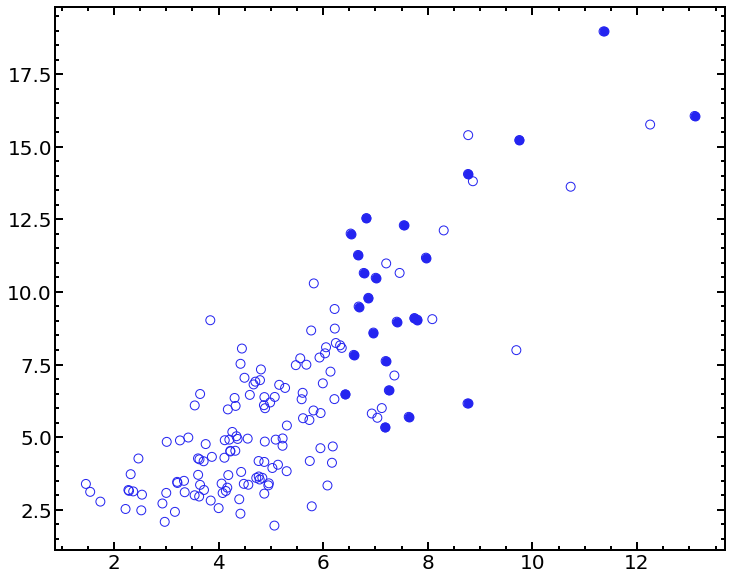

In [64]:
fig, ax = plt.subplots(figsize=(12,10))
with_both_m = (psz['m500'] > 0) & (psz['ACT_m500'] > 0)
ax.scatter(psz['m500'][with_both_m], psz['ACT_m500'][with_both_m], s=80,
           marker='o', facecolors='none', edgecolors='C0', label='All ACT in PSZ')
ax.scatter(psz['m500'][with_both_m & pszev], psz['ACT_m500'][with_both_m & pszev],
           marker='o', c='C0', s=80,
           label=f'ACT in PSZ (${evzrng[0]}<z<{evzrng[1]}$)')
ax.scatter(evolution['m500_PSZ'], evolution['m500_ACT'], marker='+', c='C1',
           linewidths=2, s=250, label='ACT in CHANCES-Ev')
ax.plot([2,18], [2,18], 'k--')
ax.set(xlim=(2,18), ylim=(2,18), #xscale='log', yscale='log',
       xlabel=r'$M_{500}^\mathrm{PSZ,Cal}\,(10^{14}$M$_\odot$)',
       ylabel=r'$M_{500}^\mathrm{ACT,Cal}\,(10^{14}$M$_\odot$)')
ax.legend()

## Additional clusters

Time to add the missing CLASH clusters

In [65]:
clash['name','hms','dms','z'][clash_not_in_psz]

name,hms,dms,z
str12,str10,str9,float64
MACSJ0329-02,03:29:40.8,-02:11:54,0.45
MACSJ1311-03,13:11:01.6,-03:10:40,0.494


Are these two in ACT?

In [66]:
sep = clash['coords'][clash_not_in_psz].separation(act['coords'][:,None])
np.min(sep, axis=0)

<Angle [0.00288758, 0.00212409] deg>

Yes!

In [67]:
jact_clash = np.argmin(sep, axis=0)
act['name','hms','dms','z'][jact_clash]

name,hms,dms,z
str19,str10,str9,float64
ACT-CL J0329.6-0211,03:29:41.0,-02:11:44,0.46
ACT-CL J1311.0-0310,13:11:01.0,-03:10:41,0.49


## Store evolution sample

In [68]:
act_evolution_mask = np.in1d(act['name'], psz['ACT_name'][in_both_massive_samples]) \
    | act_included | np.in1d(act['name'], act['name'][jact_clash])
evolution = combine_psz_act(pszev, act_evolution_mask)
evolution

index,name,index_PSZ,hms,dms,z,m500,m500lo,m500hi,hms_PSZ,dms_PSZ,z_PSZ,m500_PSZ,m500lo_PSZ,m500hi_PSZ,index_ACT,ACT_name,hms_ACT,dms_ACT,z_ACT,m500_ACT,m500lo_ACT,m500hi_ACT
int64,str19,int64,str10,str9,float64,float64,float64,float64,str10,str9,float32,float32,float32,float32,int64,str19,str10,str9,float64,float64,float64,float64
0,PSZ2 G309.43-72.86,--,00:40:49.6,-44:07:56,0.350,10.29,1.92,2.18,--,--,--,--,--,--,19,ACT-CL J0040.8-4407,00:40:49.6,-44:07:56,0.35,10.29,1.92,2.18
1,ACT-CL J0138.0-2155,--,01:38:05.1,-21:55:36,0.338,6.34,1.22,1.41,--,--,--,--,--,--,81,ACT-CL J0138.0-2155,01:38:05.1,-21:55:36,0.34,6.34,1.22,1.41
2,PSZ2 G259.98-63.43,29,02:32:16.7,-44:21:04,0.284,12.30,2.35,2.70,02:32:18.7,-44:21:40,0.28,7.54,0.32,0.33,9,ACT-CL J0232.2-4421,02:32:16.7,-44:21:04,0.28,12.30,2.35,2.70
3,PSZ2 G271.53-56.57,54,02:45:30.0,-53:02:09,0.298,10.65,2.02,2.31,02:45:28.4,-53:02:32,0.30,6.78,0.36,0.37,15,ACT-CL J0245.5-5302,02:45:30.0,-53:02:09,0.30,10.65,2.02,2.31
4,PSZ2 G205.05-62.95,27,02:46:25.8,-20:31:36,0.310,7.64,0.51,0.48,02:46:25.8,-20:31:36,0.31,7.64,0.51,0.48,--,--,--,--,--,--,--,--
5,PSZ2 G294.68-37.01,46,03:03:57.8,-77:54:11,0.274,6.99,0.32,0.29,03:03:57.8,-77:54:11,0.27,6.99,0.32,0.29,--,--,--,--,--,--,--,--
6,PSZ2 G263.03-56.19,--,03:04:14.6,-49:21:27,0.392,6.91,1.26,1.43,--,--,--,--,--,--,60,ACT-CL J0304.2-4921,03:04:14.6,-49:21:27,0.39,6.91,1.26,1.43
7,PSZ2 G223.93-60.10,47,03:07:01.9,-28:40:01,0.253,8.60,1.68,1.94,03:07:00.6,-28:41:03,0.25,6.96,0.45,0.44,30,ACT-CL J0307.0-2840,03:07:01.9,-28:40:01,0.25,8.60,1.68,1.94
8,ACT-CL J0329.6-0211,--,03:29:41.0,-02:11:44,0.459,7.84,1.44,1.63,--,--,--,--,--,--,44,ACT-CL J0329.6-0211,03:29:41.0,-02:11:44,0.46,7.84,1.44,1.63


In [69]:
cols_ = ['hms', 'dms', 'z', 'm500', 'm500lo', 'm500hi']
pszcols_ = [f'{col_}_PSZ' for col_ in cols_]
for i, row in enumerate(evolution):
    if row['name'][:4] == 'PSZ2':
        match = (psz['name'] == row['name'])
        for c, pc in zip(cols_, pszcols_):
            evolution[pc][i] = psz[c][match][0]
evolution[:5]

index,name,index_PSZ,hms,dms,z,m500,m500lo,m500hi,hms_PSZ,dms_PSZ,z_PSZ,m500_PSZ,m500lo_PSZ,m500hi_PSZ,index_ACT,ACT_name,hms_ACT,dms_ACT,z_ACT,m500_ACT,m500lo_ACT,m500hi_ACT
int64,str19,int64,str10,str9,float64,float64,float64,float64,str10,str9,float32,float32,float32,float32,int64,str19,str10,str9,float64,float64,float64,float64
0,PSZ2 G309.43-72.86,--,00:40:49.6,-44:07:56,0.350,10.29,1.92,2.18,00:40:46.6,-44:07:58,0.35,5.82,0.57,0.54,19,ACT-CL J0040.8-4407,00:40:49.6,-44:07:56,0.35,10.29,1.92,2.18
1,ACT-CL J0138.0-2155,--,01:38:05.1,-21:55:36,0.338,6.34,1.22,1.41,--,--,--,--,--,--,81,ACT-CL J0138.0-2155,01:38:05.1,-21:55:36,0.34,6.34,1.22,1.41
2,PSZ2 G259.98-63.43,29,02:32:16.7,-44:21:04,0.284,12.30,2.35,2.70,02:32:18.7,-44:21:40,0.28,7.54,0.32,0.33,9,ACT-CL J0232.2-4421,02:32:16.7,-44:21:04,0.28,12.30,2.35,2.70
3,PSZ2 G271.53-56.57,54,02:45:30.0,-53:02:09,0.298,10.65,2.02,2.31,02:45:28.4,-53:02:32,0.30,6.78,0.36,0.37,15,ACT-CL J0245.5-5302,02:45:30.0,-53:02:09,0.30,10.65,2.02,2.31
4,PSZ2 G205.05-62.95,27,02:46:25.8,-20:31:36,0.310,7.64,0.51,0.48,02:46:25.8,-20:31:36,0.31,7.64,0.51,0.48,--,--,--,--,--,--,--,--


Fixed! Storing now then

In [70]:
evolution.write('catalogues/chances_clusters_evolution_psz2_act_clash.txt',
                format='ascii.fixed_width', overwrite=True)

In [71]:
if clash['name'][clash_not_in_psz][0] not in evolution['name']:
    for cl in clash[clash_not_in_psz]:
        row = [cl[col] if col in cl.colnames else '0' for col in evolution.colnames]
        mask = ~np.in1d(evolution.colnames, cl.colnames)
        # the first is just an index
        row[0] = evolution['name'].size
        mask[0] = False
        evolution.add_row(row, mask)

In [72]:
coords_evol = SkyCoord([f'{hms} {dms}' for hms, dms in evolution['hms','dms']],
                       unit=(u.hourangle, u.deg), frame='icrs')
evolution

index,name,index_PSZ,hms,dms,z,m500,m500lo,m500hi,hms_PSZ,dms_PSZ,z_PSZ,m500_PSZ,m500lo_PSZ,m500hi_PSZ,index_ACT,ACT_name,hms_ACT,dms_ACT,z_ACT,m500_ACT,m500lo_ACT,m500hi_ACT
int64,str19,int64,str10,str9,float64,float64,float64,float64,str10,str9,float32,float32,float32,float32,int64,str19,str10,str9,float64,float64,float64,float64
0,PSZ2 G309.43-72.86,--,00:40:49.6,-44:07:56,0.350,10.29,1.92,2.18,00:40:46.6,-44:07:58,0.35,5.82,0.57,0.54,19,ACT-CL J0040.8-4407,00:40:49.6,-44:07:56,0.35,10.29,1.92,2.18
1,ACT-CL J0138.0-2155,--,01:38:05.1,-21:55:36,0.338,6.34,1.22,1.41,--,--,--,--,--,--,81,ACT-CL J0138.0-2155,01:38:05.1,-21:55:36,0.34,6.34,1.22,1.41
2,PSZ2 G259.98-63.43,29,02:32:16.7,-44:21:04,0.284,12.30,2.35,2.70,02:32:18.7,-44:21:40,0.28,7.54,0.32,0.33,9,ACT-CL J0232.2-4421,02:32:16.7,-44:21:04,0.28,12.30,2.35,2.70
3,PSZ2 G271.53-56.57,54,02:45:30.0,-53:02:09,0.298,10.65,2.02,2.31,02:45:28.4,-53:02:32,0.30,6.78,0.36,0.37,15,ACT-CL J0245.5-5302,02:45:30.0,-53:02:09,0.30,10.65,2.02,2.31
4,PSZ2 G205.05-62.95,27,02:46:25.8,-20:31:36,0.310,7.64,0.51,0.48,02:46:25.8,-20:31:36,0.31,7.64,0.51,0.48,--,--,--,--,--,--,--,--
5,PSZ2 G294.68-37.01,46,03:03:57.8,-77:54:11,0.274,6.99,0.32,0.29,03:03:57.8,-77:54:11,0.27,6.99,0.32,0.29,--,--,--,--,--,--,--,--
6,PSZ2 G263.03-56.19,--,03:04:14.6,-49:21:27,0.392,6.91,1.26,1.43,03:04:20.4,-49:21:20,0.39,4.70,0.66,0.61,60,ACT-CL J0304.2-4921,03:04:14.6,-49:21:27,0.39,6.91,1.26,1.43
7,PSZ2 G223.93-60.10,47,03:07:01.9,-28:40:01,0.253,8.60,1.68,1.94,03:07:00.6,-28:41:03,0.25,6.96,0.45,0.44,30,ACT-CL J0307.0-2840,03:07:01.9,-28:40:01,0.25,8.60,1.68,1.94
8,ACT-CL J0329.6-0211,--,03:29:41.0,-02:11:44,0.459,7.84,1.44,1.63,--,--,--,--,--,--,44,ACT-CL J0329.6-0211,03:29:41.0,-02:11:44,0.46,7.84,1.44,1.63


## Chris' evolution sample

Let's see what overlap we have

In [77]:
evolution_orig[['CHANCES name','z']].as_array()

array([('PSZ2 G286.98+32.90', 0.39  ), ('RXC J1514.9-1523', 0.2226),
       ('RXC J2248.7-4431', 0.3475), ('MACS J0416.1-2403', 0.397 ),
       ('RXC J0600.1-2007', 0.46  ), ('MACS J0553.4-3342', 0.43  ),
       ('PSZ2 G284.97-23.69', 0.39  ), ('Abell1300', 0.306 ),
       ('PSZ2 G277.76-51.74', 0.438 ), ('PSZ2 G201.50-27.31', 0.5377),
       ('RXC J1347.5-1144', 0.4516), ('PSZ2 G337.12-66.02', 0.547 ),
       ('MACS J0329.7-0211', 0.45  ), ('PSZ2 G205.93-39.46', 0.443 ),
       ('PSZ2 G262.73-40.92', 0.421 ), ('PSZ2 G241.11-28.68', 0.42  ),
       ('PSZ2 G271.18-30.95', 0.3755), ('ClG 0657-56', 0.2965),
       ('PSZ2 G259.98-63.43', 0.284 ), ('PSZ2 G205.05-62.95', 0.31  ),
       ('Abell3444', 0.2542), ('MACS J1206.2-0847', 0.44  ),
       ('RXC J1314.4-2515', 0.244 ), ('PSZ2 G325.70+17.34', 0.3155),
       ('AbellS0780', 0.236 ), ('PSZ2 G348.90-67.37', 0.358 ),
       ('PSZ2 G243.15-73.84', 0.41  ), ('MACS J1115.9+0129', 0.352 ),
       ('MACS J1311.0-0311', 0.494 ), ('Abell0521', 0.

In [74]:
evolution_orig = ascii.read('CHANCES Evolution clusters - Evolution_CHANCES.csv', format='csv')
evolution_orig.rename_columns(['Cluster', 'RA_J2000', 'Dec_J2000', 'Z', 'PSZ2', 'M_500'],
                              ['CHANCES name', 'ra', 'dec', 'z', 'PSZ_index', 'm500'])
evolution_orig.remove_columns(['Gal_Long', 'Gal_Lat'])
evolution_orig

CHANCES name,ra,dec,z,PSZ_index,m500,VISTA,Comments
str18,float64,float64,float64,int64,float64,str4,str17
PSZ2 G286.98+32.90,177.705,-28.077,0.39,1341,14.692,GCAV,--
RXC J1514.9-1523,228.742,-15.386,0.2226,1616,8.861,GCAV,--
RXC J2248.7-4431,342.181,-44.529,0.3475,1627,11.359,GCAV,CLASH-VLT MeerKAT
MACS J0416.1-2403,64.041,-24.066,0.397,993,0.0,GCAV,CLASH-VLT
RXC J0600.1-2007,90.071,-20.104,0.46,1016,10.731,GCAV,--
MACS J0553.4-3342,88.363,-33.715,0.43,1077,8.772,GCAV,--
PSZ2 G284.97-23.69,110.839,-73.439,0.39,1324,8.393,GCAV,--
Abell1300,172.977,-19.928,0.306,1292,8.97,GCAV,--
PSZ2 G277.76-51.74,43.596,-58.964,0.438,1287,9.693,GCAV,SPT-ClJ0254.8587


In [79]:
coords_orig = SkyCoord(ra=evolution_orig['ra'], dec=evolution_orig['dec'], unit='deg', frame='icrs')
sep = coords_orig.separation(coords_evol[:,None])
sep.shape

(65, 49)

In [80]:
closest = np.argmin(sep, axis=1)
matches = np.min(sep, axis=1)
(matches < 5*u.arcmin).sum()

37

In [81]:
closest = np.argmin(sep, axis=0)
mindist = np.min(sep, axis=0)
matches = (mindist < 5*u.arcmin)
evolution_orig['name'] = [evolution['name'][j] if m else '--' for j, m in zip(closest, matches)]
evolution_orig

CHANCES name,ra,dec,z,PSZ_index,m500,VISTA,Comments,name
str18,float64,float64,float64,int64,float64,str4,str17,str19
PSZ2 G286.98+32.90,177.705,-28.077,0.39,1341,14.692,GCAV,--,PSZ2 G286.98+32.90
RXC J1514.9-1523,228.742,-15.386,0.2226,1616,8.861,GCAV,--,PSZ2 G346.61+35.06
RXC J2248.7-4431,342.181,-44.529,0.3475,1627,11.359,GCAV,CLASH-VLT MeerKAT,PSZ2 G349.46-59.95
MACS J0416.1-2403,64.041,-24.066,0.397,993,0.0,GCAV,CLASH-VLT,PSZ2 G221.06-44.05
RXC J0600.1-2007,90.071,-20.104,0.46,1016,10.731,GCAV,--,--
MACS J0553.4-3342,88.363,-33.715,0.43,1077,8.772,GCAV,--,--
PSZ2 G284.97-23.69,110.839,-73.439,0.39,1324,8.393,GCAV,--,PSZ2 G284.97-23.69
Abell1300,172.977,-19.928,0.306,1292,8.97,GCAV,--,PSZ2 G278.58+39.16
PSZ2 G277.76-51.74,43.596,-58.964,0.438,1287,9.693,GCAV,SPT-ClJ0254.8587,--


In [82]:
evolution_all = join(evolution_orig['CHANCES name','VISTA','Comments','name'], evolution, keys='name', join_type='outer')
name_mask = evolution_all['CHANCES name'].mask
# need to loop to increase string length
evolution_all['CHANCES name'] = [name if mask else cname for name, cname, mask
                                 in zip(evolution_all['name'], evolution_all['CHANCES name'], name_mask)]
for i, (cl, mask) in enumerate(zip(evolution_all, evolution_all.mask)):
    if mask['z']:
        j = (cl['CHANCES name'] == evolution_orig['CHANCES name'])
        evolution_all['z'][i] = evolution_orig['z'][j]
        c = SkyCoord(ra=evolution_orig['ra'][j], dec=evolution_orig['dec'][j], unit='deg', frame='icrs')
        d = c.separation(psz['coords'])
        closest = np.argmin(d)
        if d[closest] < 5*u.arcmin:
            for col in ('name', 'hms', 'dms', 'm500', 'm500lo', 'm500hi'):
                evolution_all[col][i] = psz[col][closest]
                if f'{col}_PSZ' in evolution_all.colnames:
                    evolution_all[f'{col}_PSZ'][i] = psz[col][closest]
            evolution_all['z_PSZ'][i] = psz['z'][closest]
        else:
            evolution_all['hms'][i] = decimal2hms(c.ra[0].deg, ':')
            evolution_all['dms'][i] = decimal2dms(c.dec[0].deg, ':')
evolution_all

/tmp/ipykernel_18570/3073532805.py:20: StringTruncateWarning: truncated right side string(s) longer than 10 character(s) during assignment
  evolution_all['hms'][i] = decimal2hms(c.ra[0].deg, ':')
/tmp/ipykernel_18570/3073532805.py:21: StringTruncateWarning: truncated right side string(s) longer than 9 character(s) during assignment
  evolution_all['dms'][i] = decimal2dms(c.dec[0].deg, ':')
/tmp/ipykernel_18570/3073532805.py:20: StringTruncateWarning: truncated right side string(s) longer than 10 character(s) during assignment
  evolution_all['hms'][i] = decimal2hms(c.ra[0].deg, ':')
/tmp/ipykernel_18570/3073532805.py:21: StringTruncateWarning: truncated right side string(s) longer than 9 character(s) during assignment
  evolution_all['dms'][i] = decimal2dms(c.dec[0].deg, ':')


CHANCES name,VISTA,Comments,name,index,index_PSZ,hms,dms,z,m500,m500lo,m500hi,hms_PSZ,dms_PSZ,z_PSZ,m500_PSZ,m500lo_PSZ,m500hi_PSZ,index_ACT,ACT_name,hms_ACT,dms_ACT,z_ACT,m500_ACT,m500lo_ACT,m500hi_ACT
str19,str4,str17,str19,int64,int64,str10,str9,float64,float64,float64,float64,str10,str9,float32,float32,float32,float32,int64,str19,str10,str9,float64,float64,float64,float64
PSZ2 G304.84-41.40,SMC,--,PSZ2 G304.84-41.40,--,--,00:28:16.7,-75:38:02,0.410,7.65,0.38,0.35,00:28:16.7,-75:38:02,0.41,7.65,0.38,0.35,--,--,--,--,--,--,--,--
Abell0907,HiLx,--,PSZ2 G249.38+33.26,--,--,09:58:24.4,-11:04:08,0.167,5.41,0.37,0.33,09:58:24.4,-11:04:08,0.17,5.41,0.37,0.33,--,--,--,--,--,--,--,--
Abell0901,HiLx,--,--,--,--,09:56:26.4,-10:04:12,0.163,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
RXC J0600.1-2007,GCAV,--,PSZ2 G225.93-19.99,--,--,06:00:15.6,-20:07:27,0.460,10.73,0.54,0.51,06:00:15.6,-20:07:27,0.46,10.73,0.54,0.51,--,--,--,--,--,--,--,--
MACS J0553.4-3342,GCAV,--,PSZ2 G239.27-26.01,--,--,05:53:23.6,-33:42:07,0.430,8.77,0.46,0.44,05:53:23.6,-33:42:07,0.43,8.77,0.46,0.44,--,--,--,--,--,--,--,--
RXC J1212.3-1816,HiLx,--,--,--,--,12:12:18.9,-18:16:44,0.269,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
PSZ2 G243.15-73.84,P109,WAVES,PSZ2 G243.15-73.84,--,--,01:59:03.1,-34:14:06,0.410,8.09,0.50,0.48,01:59:03.1,-34:14:06,0.41,8.09,0.50,0.48,--,--,--,--,--,--,--,--
PSZ2 G277.76-51.74,GCAV,SPT-ClJ0254.8587,PSZ2 G277.76-51.74,--,--,02:54:16.4,-58:57:38,0.438,9.69,0.38,0.37,02:54:16.4,-58:57:38,0.44,9.69,0.38,0.37,--,--,--,--,--,--,--,--
PSZ2 G201.50-27.31,GCAV,MS 0451,PSZ2 G201.50-27.31,--,--,04:54:14.2,-03:01:08,0.538,8.30,0.73,0.70,04:54:14.2,-03:01:08,0.54,8.30,0.73,0.70,--,--,--,--,--,--,--,--


In [83]:
evolution_all.write('catalogues/chances_clusters_evolution_all.txt', format='ascii.fixed_width', overwrite=True)

## ACT multiple systems

In [84]:
act_multiple = Table(fits.getdata('/home/cristobal/Documents/actpol/advact_catalog_paper_stuff/DR5_multiplesystems_v1.0.fits'))
gal = SkyCoord(ra=act_multiple['meanRADeg'], dec=act_multiple['meanDecDeg'], unit='deg', frame='icrs').transform_to('galactic')
act_multiple['l'] = gal.l.value
act_multiple['b'] = gal.b.value
footprint = (act_multiple['l'] > 180) & np.abs(act_multiple['b'] > 10) \
    & (act_multiple['meanDecDeg'] > -80) & (act_multiple['meanDecDeg'] < 5) \
    & (act_multiple['meanRedshift'] > 0.07) & (act_multiple['meanRedshift'] < 0.5)
for col in ('meanRADeg', 'meanDecDeg', 'l', 'b'):
    act_multiple[col].format = '%.6f'
act_multiple['meanRedshift'].format = '%.2f'
for col in ('maxSeparationMpc', 'maxSeparationArcmin'):
    act_multiple[col].format = '%.1f'
act_multiple = act_multiple[footprint]
act_multiple

name,meanRADeg,meanDecDeg,meanRedshift,numClusters,maxSeparationMpc,maxSeparationArcmin,includesPhotoRedshift,tileName,l,b
str64,float64,float64,float64,int64,float64,float64,bool,str17,float64,float64
ACT-CL J0000.7+0225 / J2359.5+0208,180.033222,2.278588,0.43,2,8.1,24.2,False,1_11_7,274.451244,62.279085
ACT-CL J0824.9+0426 / J0825.9+0414,126.367761,4.341821,0.23,2,4.0,18.5,False,3_1_5,220.037649,22.861326
ACT-CL J0826.0+0419 / J0826.3+0415,126.557693,4.292520,0.47,2,2.2,6.2,True,3_1_5,220.180594,23.006134
ACT-CL J0857.8+0310 / J0859.4+0308,134.669505,3.161979,0.19,2,4.9,24.7,True,3_1_4,225.611050,29.574453
ACT-CL J0857.8+0310 / J0859.4+0308 / J0901.5+0301,134.908050,3.114431,0.19,3,5.9,31.5,True,3_1_4,225.794121,29.757999
ACT-CL J0859.4+0308 / J0901.5+0301,135.130070,3.082608,0.19,2,6.1,31.5,True,3_1_4,225.952621,29.934809
ACT-CL J0935.0+0053 / J0935.2+0048,143.784151,0.849712,0.36,2,2.0,6.6,False,3_0_3,233.631475,36.135661
ACT-CL J1031.7-0302 / J1032.1-0249,157.990954,-2.934999,0.47,2,5.0,14.3,True,3_0_2,249.218726,44.902254
ACT-CL J1258.4+0043 / J1258.8+0059,194.667400,0.865267,0.39,2,5.4,16.8,True,2_0_6,307.011742,63.679714


Let's clean the sample a little before saving:
* Remove duplicates
* Remove ``tileName`` column

In [85]:
if 'tileName' in act_multiple.colnames:
    act_multiple.remove_column('tileName')
if 'includesPhotoRedshift' in act_multiple.colnames:
    act_multiple.rename_column('includesPhotoRedshift', 'photo-z')
act_multiple = act_multiple[[0,1,2,4,6,7,8,9,11]]
act_multiple.write('catalogues/act_multiple_systems_evolution_sample.txt', format='ascii.fixed_width', overwrite=True)
act_multiple

name,meanRADeg,meanDecDeg,meanRedshift,numClusters,maxSeparationMpc,maxSeparationArcmin,photo-z,l,b
str64,float64,float64,float64,int64,float64,float64,bool,float64,float64
ACT-CL J0000.7+0225 / J2359.5+0208,180.033222,2.278588,0.43,2,8.1,24.2,False,274.451244,62.279085
ACT-CL J0824.9+0426 / J0825.9+0414,126.367761,4.341821,0.23,2,4.0,18.5,False,220.037649,22.861326
ACT-CL J0826.0+0419 / J0826.3+0415,126.557693,4.292520,0.47,2,2.2,6.2,True,220.180594,23.006134
ACT-CL J0857.8+0310 / J0859.4+0308 / J0901.5+0301,134.908050,3.114431,0.19,3,5.9,31.5,True,225.794121,29.757999
ACT-CL J0935.0+0053 / J0935.2+0048,143.784151,0.849712,0.36,2,2.0,6.6,False,233.631475,36.135661
ACT-CL J1031.7-0302 / J1032.1-0249,157.990954,-2.934999,0.47,2,5.0,14.3,True,249.218726,44.902254
ACT-CL J1258.4+0043 / J1258.8+0059,194.667400,0.865267,0.39,2,5.4,16.8,True,307.011742,63.679714
ACT-CL J1258.7-0145 / J1302.8-0230,195.196632,-2.137566,0.08,2,7.3,76.8,False,307.700742,60.647591
ACT-CL J1322.4+0408 / J1324.3+0419 / J1325.2+0357,201.002233,4.140032,0.26,3,7.4,30.5,False,323.035887,65.732413


# Plot

Galactic plane

In [ ]:
l = np.linspace(0, 360, 1000)
b = 10*np.ones(l.size)
below_gplane = SkyCoord(l, -b, unit='deg', frame='galactic')
bgp = below_gplane.transform_to('icrs')
above_gplane = SkyCoord(l, b, unit='deg', frame='galactic')
agp = above_gplane.transform_to('icrs')

German sky

In [ ]:
b = np.linspace(-90, 90, 500)
l = np.ones(b.size)
#l = np.append(np.zeros(b.size), 180*np.ones(b.size))
#b = np.append(b, b)
grsplit = SkyCoord(0*l, b, unit='deg', frame='galactic')
gr0 = grsplit.transform_to('icrs')
grsplit = SkyCoord(180*l, b, unit='deg', frame='galactic')
gr180 = grsplit.transform_to('icrs')

for ``fill_between``

In [ ]:
gr_ra = np.append(gr0.ra.deg, gr180.ra.deg)
gr_dec = np.append(gr0.dec.deg, gr180.dec.deg)
jgr = np.argsort(gr_ra)
gr_ra = gr_ra[jgr]
gr_dec = gr_dec[jgr]

In [ ]:
transform = crs.Geodetic()
kwargs = dict(transform=transform)
grcolor = 'k'
fig = plt.figure(figsize=(18,5))
ax = plt.axes(projection=crs.Mollweide())
#ax.plot(gsky.ra.value, gsky.dec.value, 'C1.', **kwargs)
#ax.plot(gsky_ra, gsky_dec, 'C2.', **kwargs)
ax.plot(bgp.ra, bgp.dec, '-', color=grcolor, lw=3, **kwargs)
ax.plot(agp.ra, agp.dec, '-', color=grcolor, lw=3, **kwargs)
# hatch the Galactic plane
bx = np.linspace(-10, 10, 10)
for l in np.linspace(180, 360, 30):
    gl = SkyCoord(l, bx, unit='deg', frame='galactic')
    gl = gl.transform_to('icrs')
    ax.plot(gl.ra.deg, gl.dec.deg, '-', color=grcolor, **kwargs)
ax.fill_between(np.linspace(0, 359.9, 100), 5*np.ones(100), 90*np.ones(100),
                color='C9', alpha=0.6, **kwargs)
#ax.plot([0, 359], [5, 5], 'C2-')
#ax.plot(gr0.ra, gr0.dec, '-', color=grcolor, lw=2, **kwargs)
#ax.plot(gr180.ra, gr180.dec, '-', color=grcolor, lw=2, **kwargs)
ax.fill_between(gr_ra, gr_dec, 90*np.ones(gr_dec.size), color='C5', alpha=0.6, **kwargs)
ax.plot(chances_ev['ra'], chances_ev['dec'], 'C0o', **kwargs, ms=5, label='Base PSZ-Ev')
ax.plot(clash['ra'][clash_chances_mask], clash['dec'][clash_chances_mask],
        'C1+', **kwargs, ms=8, mew=2.5, label='CLASH-VLT')
ax.plot(act['ra'][act_included], act['dec'][act_included], 'C2^',
        **kwargs, ms=6, label='Additional ACT')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#ax.set(xlabel='RA (deg)', ylabel='Dec (deg)')
#ax.set_ylim(-90, 90)
ax.legend(loc=(0.20,0.5), framealpha=0.8)

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
pz = psz[pszcols['z']]
pm = psz[pszcols['m500']]
az = act[actcols['z']]
am = act[actcols['m500']]
pcolor = 'C3'
acolor = 'C0'
ax.plot(pz[~lowz & ~pszev], pm[~lowz & ~pszev], 'o', color=pcolor, label='PSZ2', alpha=0.6)
ax.plot(az [~actev], am[~actev], 'o', color=acolor, label='AdvACT', alpha=0.6)
# low-z
ax.plot(pz[lowz], pm[lowz], 'x', color=pcolor, ms=8, mew=3, label=f'$N_\mathrm{{lowz}}^\mathrm{{PSZ}}={lowz.sum()}$')
# Evolution
ax.plot(pz[pszev], pm[pszev], '+', color=pcolor, ms=8, mew=3, label=f'$N_\mathrm{{ev}}^\mathrm{{PSZ}}={pszev.sum()}$')
ax.plot(az[actev], am[actev], '+', color=acolor, ms=8, mew=3, label=f'$N_\mathrm{{ev}}^\mathrm{{ACT}}={actev.sum()}$')

# bounds
ax.plot([lowzrng[0],lowzrng[0],lowzrng[1],lowzrng[1]], [20,mmin_lowz,mmin_lowz,20], 'k:')
ax.plot([evzrng[0], evzrng[0],evzrng[1],evzrng[1]], [20,mevmin,mevmin,20], 'k:')

ax.set(xscale='log', yscale='log',
       xlabel='Redshift', ylabel='$M_\mathrm{500c}$ ($10^{14}$ M$_\odot$)')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%s'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
zbins = np.logspace(-1.7, 0.3, 21)
ax.hist(pz[lowz], zbins, color=pcolor, histtype='step', lw=2, label='PSZ Low-z')
ax.hist(pz[pszev], zbins, color=pcolor, histtype='stepfilled', label='PSZ Evolution')
ax.hist(az[actev], zbins, color=acolor, histtype='step', lw=2, label='ACT Evolution')
ax.set(xscale='log', xlabel='Redshift', ylabel='N(z)')
ax.legend()

Galactic plane

In [ ]:
glat = np.array([-10, 0, 10])
l = np.arange(-180, 180, 0.1)
gra = []
gdec = []
for b in glat:
    gplane = SkyCoord(l*u.deg, b*np.ones(l.size)*u.deg, frame='galactic')
    g = gplane.transform_to('icrs')
    gra.append(g.ra.value)
    gdec.append(g.dec.value)
gra = np.array(gra)
gdec = np.array(gdec)
gra[gra > 180] = gra[gra > 180] - 360
#j = np.argsort(gra, axis=0)
#gra = np.array([x[i] for x, i in zip(gra, j)])
#gdec = np.array([y[i] for y, i in zip(gdec, j)])
gra[1]

In [ ]:
jj = np.arange(l.size, dtype=int)


German/Russian divide

In [ ]:
n = 2000
b = np.linspace(-90, 90, n//2)
german_sky = SkyCoord(
    np.hstack(np.array([0,180])[:,None]*np.ones(n//2)),
    np.hstack([b, b]), unit='deg', frame='galactic')
gsky = german_sky.transform_to('icrs')
gsky_ra = gsky.ra.value
gsky_dec = gsky.dec.value
neg = gsky_ra > 180
gsky_ra[neg] = gsky_ra[neg] - 360
# sort so we can use lines to plot
j0 = np.argsort(gsky_ra)
gsky_ra = gsky_ra[j0]
gsky_dec = gsky_dec[j0]

Brute force

In [ ]:
def plot(ax, ra, dec, *args, **kwargs):
    if not isinstance(ra, u.Quantity):
        ra = ra*u.deg
    if not isinstance(dec, u.Quantity):
        dec = dec*u.deg
    #ra[ra > 180] -= 180
    #j = np.argsort(ra)
    #ra = ra[j]
    #dec = dec[j]
    ax.plot(ra.to('rad'), dec.to('rad'), *args, **kwargs)
    return

In [ ]:
def rad(x):
    return np.pi/180 * x

In [ ]:
gra.shape

In [ ]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection='aitoff')
ax.fill_between(rad(gsky_ra), rad(gsky_dec), np.pi/2*np.ones(gsky_ra.size), color='C2', alpha=0.2)
#ax.plot(np.pi/180*raplane, np.pi/180*decplane, 'kx')
plot(ax, gra[1][:-1], gdec[1][:-1], 'k-')
#cat, cols, mask = act, actcols, actmask
#ax.plot(np.pi/180*cat[cols['ra']][~mask], np.pi/180*cat[cols['dec']][~mask], 'C0,')
#ax.plot(np.pi/180*cat[cols['ra']][mask], np.pi/180*cat[cols['dec']][mask], 'C0x', ms=4, mew=2)
#plot(ax, cat[cols['ra']][~mask], cat[cols['dec']][~mask], 'C0o', ms=2)
#cat, cols, mask = psz, pszcols, pszmask
#ax.plot(np.pi/180*cat[cols['ra']][~mask], np.pi/180*cat[cols['dec']][~mask], 'C3.', ms=2)
#ax.plot(np.pi/180*cat[cols['ra']][mask], np.pi/180*cat[cols['dec']][mask], 'C3+', ms=4, mew=2)
ax.grid()

In [ ]:
proj = skm.Mollweide(lon_0=0)
skmap = skm.Map(proj, interactive=False)
skmap.fig.set_size_inches(18, 9)
cat, cols, mask = act, actcols, actmask
skmap.plot(cat[cols['ra']][~mask], cat[cols['dec']][~mask], 'C0,')#, transform=crs.Geodetic())
skmap.plot(cat[cols['ra']][mask], cat[cols['dec']][mask], 'C0x', ms=4, mew=2)#, transform=crs.Geodetic())
cat, cols, mask = psz, pszcols, pszmask
skmap.plot(cat[cols['ra']][~mask], cat[cols['dec']][~mask], 'C3,')#, transform=crs.Geodetic())
skmap.plot(cat[cols['ra']][mask], cat[cols['dec']][mask], 'C3+', ms=4, mew=2)#, transform=crs.Geodetic())
# Galactic plane
skmap.plot(gra[0], gdec[0], 'k-', lw=3)
skmap.plot(gra[1], gdec[1], 'k--', lw=1)
skmap.plot(gra[2], gdec[2], 'k-', lw=3)
skmap.plot(gsky.ra.value, gsky.dec.value, 'C1-', lw=3)
skmap.grid()

In [ ]:
help(skm.Map)

In [ ]:
transform=crs.Geodetic()
kwargs = dict(transform=transform)
fig = plt.figure(figsize=(18,5))
ax = plt.axes(projection=crs.Mollweide())
#ax.plot(gsky.ra.value, gsky.dec.value, 'C1.', **kwargs)
ax.plot(gsky_ra, gsky_dec, 'C2.', **kwargs)
cat, cols, mask = act, actcols, actmask
ax.plot(cat[cols['ra']][~mask], cat[cols['dec']][~mask], 'C0,', **kwargs)
ax.plot(cat[cols['ra']][mask], cat[cols['dec']][mask], 'C0x', ms=4, mew=2, **kwargs)
cat, cols, mask = psz, pszcols, pszmask
ax.plot(cat[cols['ra']][~mask], cat[cols['dec']][~mask], 'C3,', **kwargs)
ax.plot(cat[cols['ra']][mask], cat[cols['dec']][mask], 'C3+', ms=4, mew=2, **kwargs)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#ax.set(xlabel='RA (deg)', ylabel='Dec (deg)')
#ax.set_ylim(-90, 90)

Match both catalogues

In [ ]:
actcoords = SkyCoord(ra=act[actcols['ra']][actmask]*u.deg, dec=act[actcols['dec']][actmask]*u.deg)
pszcoords = SkyCoord(ra=psz[pszcols['ra']][pszmask]*u.deg, dec=psz[pszcols['dec']][pszmask]*u.deg)
dist = actcoords.separation(pszcoords[:,None])
dist.shape

In [ ]:
maxdist = 1 * u.arcmin
closest_to_act = np.argmin(dist, axis=0)
closest_to_psz = np.argmin(dist, axis=1)
matches_to_act = (np.min(dist, axis=0) <= maxdist)
matches_to_psz = (np.min(dist, axis=1) <= maxdist)
matches_to_act.sum(), matches_to_psz.sum()